### Sector Rotational Momentum Trading Program with SVM Regression Predicitons

The program presented here is a sector rotational momentum program which incorporates SVM regression predictions in addition to A_periods, B_periods, and S_periods scoring.

The ETF list evaluated is the same as in the Baseline model and is listed below:
- 'XLU'
- 'XLV'
- 'DIA'
- 'GDX'
- 'XLE'
- 'XLY'
- 'VNQ'
- 'XLK'
- 'XLF'
- 'XLP'
- 'IHI'
- 'XRT'
- 'RXI'
- 'IYW'
- 'VIS'
- 'KBE'
- 'SIL'
- 'FXU'
- 'SHY'

A combination of yfinance and WRDS ETF data is used. For A_periodss, B_periods, and S_periods scores, yahoo finance data is used, while for ML predcitions, WRDS data is used.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 10 10:42:09 2018

@author: Bryan Tarras (modified), Rosario (original)
"""

import pandas as pd
import numpy as np
import math
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import detrendPrice
import WhiteRealityCheckFor1

import yfinance as yf
#yf.pdr_override() # <== that's all it takes :-)

In [2]:
counter_risk_stock = 0 #Superceded variable can probably be deleted
counter_risk_bond = 0 #Superceded variable can probably be deleted

In [3]:
def getDate(dt):
    if type(dt) != str:
        return dt
    try:
        datetime_object = datetime.datetime.strptime(dt, '%Y-%m-%d')
    except Exception:
        datetime_object = datetime.datetime.strptime(dt, '%m/%d/%Y')
        return datetime_object
    else:
        return datetime_object

In [4]:
#Training Data Set Data
start_date_training = '2010-01-05'
end_date_training = '2016-12-30'

#Test Data Set Data
start_date_training = '2017-01-03'
end_date_training = '2018-08-06'

### The Cells below are to download the data sets for Training and Test Sets

Need to run it to generate the proper csv files

***Only need to run this once per stock_list combination

Below is to download the training data and test data and store in csv files with the suffix "_training" or "_test"

In [5]:
#Example1
# download dataframe
#data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
# download Panel
#data2 = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
#example2
#start = datetime.datetime(2017, 1, 1)
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)
#data.to_csv("C:\\Users\\Rosario\\Documents\\NeuralNetworksMachineLearning\\LSTMReturnPrediction\\data\\YahooSPY.csv")

#start_date=datetime.datetime(2003, 1, 1)
start_date_training=datetime.datetime(2010, 1, 5)
#end_date= datetime.datetime.now()
end_date_training=datetime.datetime(2016, 12, 30)

start_date_test=datetime.datetime(2017, 1, 3)
#end_date= datetime.datetime.now()
end_date_test=datetime.datetime(2018, 8, 6)


stock_list = ['XLU','XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']
#stock_list = ["SPY", "BND", "TLT"]
#stock_list = ["SPY", "TLT"]
#stock_list = ["SPY", "TLT", "SHY"]


stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."


#Below is for AP training data download    
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_training)
     df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
    

main_df.to_csv(stock_str+"AP_train.csv")


#Below is for normal prices training data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_training)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"train.csv")

#Below is for AP test data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_test, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"AP_test.csv")

#Below is for normal price test data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_test, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"test.csv")



### Training Data Section
The secion bleow will read in the training data and proceed to run the trading algorithm on this training data set

In [6]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.train.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_train.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [7]:
dfP.shape

(1761, 19)

In [8]:
dfP.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,30.709999,31.299999,105.489998,48.169998,59.290001,30.110001,44.500000,23.240000,12.152721,26.680000,53.779999,18.084999,44.410000,58.400002,52.770000,22.180000,NaN,15.45,83.169998
2010-01-06,30.889999,31.620001,105.559998,49.340000,60.000000,30.150000,44.419998,22.980000,12.177092,26.660000,54.389999,18.250000,44.430000,57.990002,52.900002,22.469999,NaN,15.47,83.180000
2010-01-07,30.750000,31.730000,105.940002,49.099998,59.910000,30.400000,44.900002,22.889999,12.437043,26.660000,54.630001,18.299999,44.650002,57.770000,53.549999,23.410000,NaN,15.41,83.160004
2010-01-08,30.719999,31.780001,106.110001,49.840000,60.299999,30.389999,44.570000,23.040001,12.363932,26.570000,54.689999,18.260000,45.009998,58.209999,54.259998,23.320000,NaN,15.35,83.239998
2010-01-11,31.040001,31.959999,106.540001,50.169998,60.220001,30.330000,44.830002,22.950001,12.372055,26.639999,55.029999,18.205000,45.200001,57.930000,54.770000,23.330000,NaN,15.49,83.279999


In [9]:
dfAP.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2016-12-23,44.442898,66.537178,186.965958,19.084234,69.879646,79.567932,72.273666,47.078487,22.429367,48.298004,132.494278,42.660793,87.801529,119.185059,115.131683,41.815819,29.729496,24.856861,80.495987
2016-12-27,44.479473,66.671288,187.116196,19.607225,70.035233,79.876732,72.425667,47.270756,22.457905,48.288719,132.752167,43.073219,87.907364,119.741531,115.351059,41.986961,30.528627,24.912346,80.457802
2016-12-28,44.058903,66.163589,186.054825,19.972334,69.275581,79.326668,71.987488,46.847755,22.229618,47.991844,131.919022,42.555294,87.532143,118.589516,114.092064,41.597141,31.082760,24.671917,80.486427
2016-12-29,44.653187,66.278542,185.970322,21.462362,69.138275,79.220520,72.881737,46.857368,22.067909,48.214500,132.216583,42.440205,87.166534,118.501640,114.120667,41.245350,33.238281,24.912346,80.572304
2016-12-30,44.406326,66.039070,185.519440,20.643339,68.936935,78.554649,73.802818,46.492046,22.115473,47.973286,132.057877,42.267570,86.743217,117.398438,113.748695,41.330914,31.604418,24.718153,80.600952


In [10]:
#Reading in the predictions from the SVM model

dfRF_C_train = pd.read_csv('svm-regression-ETF-train-predictions.csv')

print (dfRF_C_train.shape)

(1761, 20)


In [11]:
#dfRF_C_train = dfRF_C_train.drop('Unnamed: 0', axis=1)

In [12]:
dfRF_C_train.set_index('Date', inplace=True)

In [13]:
dfRF_C_train.head()

,FXU,GDX,KBE,RXI,VNQ,XLP,XRT,DIA,IHI,IYW,SHY,VIS,XLE,XLF,XLK,XLU,XLV,XLY,SIL
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,0.040345,0.262924,0.039081,0.023179,0.100953,0.039344,0.057218,0.033316,0.063475,0.030893,0.002243,0.027589,-0.050642,0.028835,0.031500,0.009600,-0.002151,-0.021389,-0.059344
2010-01-06,0.040345,0.258057,0.039081,0.022570,0.101474,0.039344,0.057542,0.031370,0.063498,0.025004,0.002243,0.035728,-0.048487,0.028657,0.023177,0.008225,-0.014345,-0.013690,-0.059328
2010-01-07,0.040345,0.255706,0.039081,0.022779,0.098477,0.039344,0.058658,0.031122,0.063502,0.022194,0.002243,0.038547,-0.047245,0.028525,0.022904,0.006425,-0.020018,-0.021305,-0.059282
2010-01-08,0.040345,0.228303,0.039081,0.020042,0.101268,0.039344,0.056540,0.030893,0.063381,0.016889,0.002243,0.042080,-0.043613,0.027900,0.015699,0.006322,-0.019199,-0.016152,-0.059163
2010-01-11,0.040345,0.234156,0.039081,0.019949,0.100386,0.039344,0.055056,0.025682,0.063283,0.025431,0.002243,0.045092,-0.043993,0.025382,0.019163,0.007326,-0.020394,-0.010325,-0.059275


In [14]:
dfRF_C_train.tail()

,FXU,GDX,KBE,RXI,VNQ,XLP,XRT,DIA,IHI,IYW,SHY,VIS,XLE,XLF,XLK,XLU,XLV,XLY,SIL
Date,,,,,,,,,,,,,,,,,,,
2016-12-23,0.040324,-0.059322,0.039023,0.003879,0.021284,0.039335,-0.008341,0.034875,0.104277,0.092528,0.002243,0.058841,-0.034450,0.03002,0.067049,0.015978,0.039330,0.040921,NaN
2016-12-27,0.040327,-0.069498,0.038851,0.007029,0.022967,0.039335,-0.019094,0.034875,0.107955,0.097103,0.002243,0.059654,-0.035132,0.03002,0.066876,0.013796,0.039320,0.038121,NaN
2016-12-28,0.040334,-0.078206,0.039072,0.012546,0.029777,0.039338,-0.009900,0.034875,0.103989,0.099039,0.002243,0.061326,-0.035897,0.03002,0.067003,0.016592,0.039320,0.044846,NaN
2016-12-29,0.040333,-0.064217,0.039039,0.012679,0.016123,0.039334,-0.016480,0.034875,0.105727,0.099699,0.002243,0.061873,-0.033565,0.03002,0.066865,0.016601,0.039306,0.044812,NaN
2016-12-30,0.040334,-0.040488,0.039051,0.012062,0.001153,0.039331,0.000882,0.034875,0.101922,0.091921,0.002243,0.068667,-0.026260,0.03002,0.064098,0.010493,0.039305,0.047155,NaN


In [15]:
dfRF_C_train = dfRF_C_train[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [16]:
dfRF_C_train.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,0.009600,-0.002151,0.033316,0.262924,-0.050642,-0.021389,0.100953,0.031500,0.028835,0.039344,0.063475,0.057218,0.023179,0.030893,0.027589,0.039081,-0.059344,0.040345,0.002243
2010-01-06,0.008225,-0.014345,0.031370,0.258057,-0.048487,-0.013690,0.101474,0.023177,0.028657,0.039344,0.063498,0.057542,0.022570,0.025004,0.035728,0.039081,-0.059328,0.040345,0.002243
2010-01-07,0.006425,-0.020018,0.031122,0.255706,-0.047245,-0.021305,0.098477,0.022904,0.028525,0.039344,0.063502,0.058658,0.022779,0.022194,0.038547,0.039081,-0.059282,0.040345,0.002243
2010-01-08,0.006322,-0.019199,0.030893,0.228303,-0.043613,-0.016152,0.101268,0.015699,0.027900,0.039344,0.063381,0.056540,0.020042,0.016889,0.042080,0.039081,-0.059163,0.040345,0.002243
2010-01-11,0.007326,-0.020394,0.025682,0.234156,-0.043993,-0.010325,0.100386,0.019163,0.025382,0.039344,0.063283,0.055056,0.019949,0.025431,0.045092,0.039081,-0.059275,0.040345,0.002243


### In the cell blocks below we need to optimize the following:
    - Aperiods
    - Bperiods
    - Speriods
    
We should run with the following parameter spread:
    - Aperiods = [10, 15, 20, 30, 40, 50, 120, 200, 240, 300]
    - Bperiods = [10, 15, 20, 30, 40, 50, 120, 200, 240, 300]
    - Speriods = [1, 5, 10, 15, 20, 25, 30, 35]
    - Frequency = '20W-Thu'
    
Evaluation fo which ETF is to be selected will occur on the Aperiods score, Bperiods score, Speriods score, and the predictions from the RF model lagged at 20 weeks.

In [17]:
def stock_etf_optimization (Aperiods, Bperiods, Speriods, counter_risk_stock, df_place_holder):
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    #Aperiods = 10 #20 Default
    #Bperiods = 10 #66 Default
    #Speriods = 20 #20 Default
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
#######ADDTION OF SVM PREDICTIONS 

    dfRF_ranks = dfRF_C_train.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_C_train.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE SVM SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penializd
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    

    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
        
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        #Line below is where we multiply the returns stored in column_R by 0.33 for equal investment in all top 3 perfroming ETFs
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    #dfPRR['I'].plot()
    #plt.legend()
    #plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    df_place_holder = [(TotaAnnReturn*100),(CAGR*100),(round(sharpe,2)), (Aperiods), (Bperiods), (Speriods), (Frequency)]
    
    return (df_place_holder)

Need to make a dataframe that stores annual returns, CAGR, Sharpe Ratio, Average Return, Aperiods, Bperiods, frequency 

In [23]:
Aperiods = [10, 15, 20, 30, 40, 50]
Bperiods = [10, 15, 20, 30, 40, 50]
Speriods = [1, 5, 10, 15, 20, 25, 30, 35]
#frequency = ['8W-MON', '8W-TUE', '8W-WED', '8W-THU', '8W-FRI', '20W-MON', '20W-TUE', '20W-WED', '20W-THU', '20W-FRI', '40W-MON', '40W-TUE', '40W-WED', '40W-THU', '40W-FRI']

In [24]:
#Uncomment the below for testingpurposes only
#Aperiods = [10]
#Bperiods = [20]
#Speriods = [1]

In [25]:
df_place_holder = pd.DataFrame(np.nan, index=['results'], columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','frequency'])

In [26]:
df_stock_etf_optimal_list = [[0]*6]

In [27]:
counter = 0
counter_risk_stock = 0

In [28]:
for x in Aperiods:
    for z in Bperiods:
        for y in (Speriods):
            counter = counter + 1
            test = stock_etf_optimization (x,z,y,counter_risk_stock,df_place_holder)
            df_stock_etf_optimal_list.append(test)
            print (counter)

TotaAnnReturn = 47.543415
CAGR = 22.420000
Sharpe Ratio = 1.160000
1
TotaAnnReturn = 59.751465
CAGR = 25.490000
Sharpe Ratio = 1.380000
2
TotaAnnReturn = 67.077945
CAGR = 27.130000
Sharpe Ratio = 1.440000
3
TotaAnnReturn = 47.431349
CAGR = 22.390000
Sharpe Ratio = 1.480000
4
TotaAnnReturn = 46.249015
CAGR = 22.070000
Sharpe Ratio = 1.460000
5
TotaAnnReturn = 52.384943
CAGR = 23.700000
Sharpe Ratio = 1.610000
6
TotaAnnReturn = 47.765402
CAGR = 22.480000
Sharpe Ratio = 1.550000
7
TotaAnnReturn = 47.387376
CAGR = 22.380000
Sharpe Ratio = 1.520000
8
TotaAnnReturn = 42.769030
CAGR = 21.080000
Sharpe Ratio = 0.920000
9
TotaAnnReturn = 54.109527
CAGR = 24.130000
Sharpe Ratio = 1.260000
10
TotaAnnReturn = 68.763193
CAGR = 27.490000
Sharpe Ratio = 1.450000
11
TotaAnnReturn = 42.132526
CAGR = 20.890000
Sharpe Ratio = 1.380000
12
TotaAnnReturn = 43.629351
CAGR = 21.330000
Sharpe Ratio = 1.400000
13
TotaAnnReturn = 49.617317
CAGR = 22.980000
Sharpe Ratio = 1.470000
14
TotaAnnReturn = 51.585184
CAG

TotaAnnReturn = 44.851362
CAGR = 21.670000
Sharpe Ratio = 1.330000
118
TotaAnnReturn = 44.851362
CAGR = 21.670000
Sharpe Ratio = 1.330000
119
TotaAnnReturn = 44.851362
CAGR = 21.670000
Sharpe Ratio = 1.330000
120
TotaAnnReturn = 62.580665
CAGR = 26.140000
Sharpe Ratio = 1.160000
121
TotaAnnReturn = 62.116005
CAGR = 26.040000
Sharpe Ratio = 1.160000
122
TotaAnnReturn = 34.208862
CAGR = 18.400000
Sharpe Ratio = 1.110000
123
TotaAnnReturn = 40.244084
CAGR = 20.320000
Sharpe Ratio = 1.230000
124
TotaAnnReturn = 38.190303
CAGR = 19.690000
Sharpe Ratio = 1.230000
125
TotaAnnReturn = 38.190303
CAGR = 19.690000
Sharpe Ratio = 1.230000
126
TotaAnnReturn = 40.944562
CAGR = 20.540000
Sharpe Ratio = 1.250000
127
TotaAnnReturn = 36.804736
CAGR = 19.250000
Sharpe Ratio = 1.200000
128
TotaAnnReturn = 72.189617
CAGR = 28.200000
Sharpe Ratio = 1.220000
129
TotaAnnReturn = 33.710598
CAGR = 18.230000
Sharpe Ratio = 0.930000
130
TotaAnnReturn = 26.938998
CAGR = 15.780000
Sharpe Ratio = 0.970000
131
TotaAn

TotaAnnReturn = 24.651179
CAGR = 14.870000
Sharpe Ratio = 0.910000
234
TotaAnnReturn = 30.734037
CAGR = 17.190000
Sharpe Ratio = 1.040000
235
TotaAnnReturn = 30.155611
CAGR = 16.980000
Sharpe Ratio = 1.040000
236
TotaAnnReturn = 30.559095
CAGR = 17.130000
Sharpe Ratio = 1.050000
237
TotaAnnReturn = 33.744638
CAGR = 18.240000
Sharpe Ratio = 1.150000
238
TotaAnnReturn = 34.906576
CAGR = 18.630000
Sharpe Ratio = 1.180000
239
TotaAnnReturn = 33.136745
CAGR = 18.030000
Sharpe Ratio = 1.150000
240
TotaAnnReturn = 30.834310
CAGR = 17.230000
Sharpe Ratio = 0.840000
241
TotaAnnReturn = 37.415553
CAGR = 19.450000
Sharpe Ratio = 1.200000
242
TotaAnnReturn = 41.122564
CAGR = 20.590000
Sharpe Ratio = 1.320000
243
TotaAnnReturn = 37.923572
CAGR = 19.610000
Sharpe Ratio = 1.330000
244
TotaAnnReturn = 36.953704
CAGR = 19.300000
Sharpe Ratio = 1.310000
245
TotaAnnReturn = 39.339585
CAGR = 20.050000
Sharpe Ratio = 1.360000
246
TotaAnnReturn = 36.432987
CAGR = 19.130000
Sharpe Ratio = 1.290000
247
TotaAn

In [29]:
df_stock_etf_optimal=pd.DataFrame(df_stock_etf_optimal_list,columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','Frequency'])

In [30]:
print (df_stock_etf_optimal.nlargest(50, 'TotaAnnReturn'))

     TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods  \
225      78.103483  29.37          1.26        40        40         1   
81       75.563815  28.88          1.24        15        40         1   
201      75.563815  28.88          1.24        40        15         1   
129      72.189617  28.20          1.22        20        40         1   
209      72.189617  28.20          1.22        40        20         1   
177      70.844748  27.93          1.21        30        40         1   
217      70.844748  27.93          1.21        40        30         1   
66       70.367872  27.83          1.20        15        20         5   
106      70.367872  27.83          1.20        20        15         5   
74       69.434286  27.63          1.22        15        30         5   
154      69.434286  27.63          1.22        30        15         5   
11       68.763193  27.49          1.45        10        15        10   
51       68.763193  27.49          1.45        15  

In [31]:
print (df_stock_etf_optimal.nlargest(50, 'Sharpe Ratio'))

     TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods  \
6        52.384943  23.70          1.61        10        10        25   
7        47.765402  22.48          1.55        10        10        30   
40       51.165883  23.39          1.55        10        40        35   
200      51.165883  23.39          1.55        40        10        35   
30       49.075125  22.84          1.53        10        30        25   
150      49.075125  22.84          1.53        30        10        25   
8        47.387376  22.38          1.52        10        10        35   
39       49.251204  22.88          1.51        10        40        30   
199      49.251204  22.88          1.51        40        10        30   
15       51.585184  23.49          1.50        10        15        30   
21       46.284809  22.08          1.50        10        20        20   
22       46.284809  22.08          1.50        10        20        25   
23       46.660422  22.18          1.50        10  

The line below is for outputting results to a csv file.

In [33]:
df_stock_etf_optimal.to_csv('APS1052_df_stock_etf_optimal_training_results_top_one_with_prediction_SVM_Regression.csv', header = True, index=True, encoding='utf-8')

#### Okay the next step is to use the optimal parameters from the training data identified above to plot an equity curve for the stock etfs

In [29]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

#dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.train.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.AP_train.csv', parse_dates=['Date'])

#dfP = dfP.sort_values(by='Date')
#dfAP = dfAP.sort_values(by='Date')
#dfP.set_index('Date', inplace = True)
#dfAP.set_index('Date', inplace = True)

In [34]:
def stock_etf_optimized_parameters():    
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 40 #20 Default
    Bperiods = 40 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_C_train.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_C_train.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE SVM SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penializd
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return (stock_etf_df_R1, stock_etf_df_R2, stock_etf_df_R3, stock_etf_df_R4, stock_etf_df_R5, stock_etf_df_Sharpe_1, stock_etf_df_Sharpe_2, stock_etf_df_Sharpe_3, stock_etf_df_Sharpe_4, stock_etf_df_Sharpe_5)

Number of times "XLU" is selected 0.000000 
Number of times "XLV" is selected 410.000000 
Number of times "DIA" is selected 11.000000 
Number of times "GDX" is selected 312.000000 
Number of times "XLE" is selected 149.000000 
Number of times "XLY" is selected 189.000000 
Number of times "VNQ" is selected 115.000000 
Number of times "XLK" is selected 108.000000 
Number of times "XLF" is selected 173.000000 
Number of times "XLP" is selected 4.000000 
Number of times "IHI" is selected 82.000000 
Number of times "XRT" is selected 64.000000 
Number of times "RXI" is selected 10.000000 
Number of times "IYW" is selected 14.000000 
Number of times "VIS" is selected 6.000000 
Number of times "KBE" is selected 6.000000 
Number of times "SIL" is selected 0.000000 
Number of times "FXU" is selected 40.000000 
Number of times "SHY" is selected 68.000000 


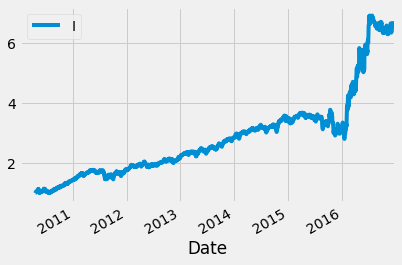

TotaAnnReturn = 78.103483
CAGR = 29.370000
Sharpe Ratio = 1.260000
Standard Deviation = 0.015566


In [35]:
stock_etf_df_R1, stock_etf_df_R2, stock_etf_df_R3, stock_etf_df_R4, stock_etf_df_R5, stock_etf_df_Sharpe_1, stock_etf_df_Sharpe_2, stock_etf_df_Sharpe_3, stock_etf_df_Sharpe_4, stock_etf_df_Sharpe_5 = stock_etf_optimized_parameters()

### Performance on test data set

What we want to do is take that df_stock_etf_optimal dataframe, extract the top 50 parameter combinations on the training data and run it on the test data to see which combinations performs best. Use the best as the total portfolio parameters to be used on the entire dataset.

In [36]:
df_stock_optimal_training_results = df_stock_etf_optimal.nlargest(50, 'TotaAnnReturn')
df_stock_optimal_training_results = df_stock_optimal_training_results.drop(['TotaAnnReturn', 'CAGR', 'Sharpe Ratio'], axis = 1)

In [37]:
df_stock_optimal_training_results = df_stock_optimal_training_results.reset_index(drop = True) 

In [38]:
df_stock_optimal_training_results.head(100)

,Aperiods,Bperiods,Speriods,Frequency
0,40,40,1,20W-THU
1,15,40,1,20W-THU
2,40,15,1,20W-THU
3,20,40,1,20W-THU
4,40,20,1,20W-THU
5,30,40,1,20W-THU
6,40,30,1,20W-THU
7,15,20,5,20W-THU
8,20,15,5,20W-THU
9,15,30,5,20W-THU


In [39]:
Aperiods_training = []
Bperiods_training = []
Speriods_training = []

clm = list(df_stock_optimal_training_results)
for x in range (0,50):
    Aperiods_training.append(df_stock_optimal_training_results['Aperiods'][x])
    Bperiods_training.append(df_stock_optimal_training_results['Bperiods'][x])
    Speriods_training.append(df_stock_optimal_training_results['Speriods'][x])

print (Aperiods_training, Bperiods_training, Speriods_training)

[40, 15, 40, 20, 40, 30, 40, 15, 20, 15, 30, 10, 15, 10, 15, 30, 15, 20, 10, 20, 20, 30, 20, 30, 15, 30, 10, 30, 10, 30, 15, 40, 50, 10, 15, 10, 40, 15, 10, 15, 30, 10, 40, 10, 20, 10, 15, 10, 40, 10] [40, 40, 15, 40, 20, 40, 30, 20, 15, 30, 15, 15, 10, 10, 30, 15, 20, 15, 20, 10, 30, 20, 30, 20, 30, 15, 10, 30, 30, 10, 40, 15, 50, 15, 10, 40, 10, 15, 10, 30, 15, 40, 10, 20, 10, 15, 10, 40, 10, 15] [1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 30, 30, 10, 10, 10, 10, 1, 1, 5, 5, 25, 25, 5, 1, 10, 10, 5, 5, 1, 5, 5, 1, 1, 5, 25, 10, 10, 5, 5, 5, 5, 30, 30, 35, 35, 35]


With the best 50 results from the training data set stored in the respective lists Aperiods_training, Bperiods_training, and frequency_training, the function below will be called to iterate over these combinations to determine perfromane on the test data set.

In [40]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.test.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_test.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [41]:
print (dfP.shape)
print (dfAP.shape)

(402, 19)
(402, 19)


In [42]:
dfP = dfP.drop(dfP.index[0])
dfAP = dfAP.drop(dfAP.index[0])

In [43]:
print (dfP.shape)
print (dfAP.shape)

(401, 19)
(401, 19)


In [44]:
dfP.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,52.450001,88.949997,253.110001,21.110001,76.050003,110.720001,82.519997,71.559998,27.950001,53.119999,208.710007,49.049999,116.129997,184.350006,143.289993,48.580002,27.25,26.129999,83.059998
2018-08-02,52.709999,89.279999,253.100006,20.940001,75.629997,111.480003,82.190002,72.459999,27.959999,53.660000,210.380005,49.560001,116.209999,187.070007,143.289993,49.009998,26.90,26.379999,83.110001
2018-08-03,53.299999,89.809998,254.389999,21.160000,75.239998,111.860001,83.080002,72.720001,28.120001,54.290001,210.160004,49.990002,116.769997,187.710007,143.479996,48.860001,27.23,26.590000,83.120003
2018-08-06,53.340000,89.970001,254.850006,20.900000,75.519997,112.610001,82.970001,73.110001,28.270000,54.340000,210.559998,50.290001,116.620003,189.210007,143.789993,48.900002,26.90,27.059999,83.139999
2018-08-07,53.259998,89.980003,256.119995,20.660000,76.080002,113.129997,82.820000,73.389999,28.400000,54.009998,210.270004,50.709999,117.730003,189.639999,144.770004,49.040001,26.84,27.030001,83.110001


In [45]:
#Reading in the predictions on the test set from the SVM model

dfRF_test = pd.read_csv('svm-regression-ETF-predictions.csv')

print (dfRF_test.shape)

(401, 20)


In [46]:
dfRF_test.set_index('Date', inplace=True)

In [47]:
dfRF_test = dfRF_test[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [48]:
dfRF_test.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2017-01-04,0.011983,0.039306,0.034875,-0.101766,-0.025778,0.036916,0.009236,0.061634,0.03002,0.039330,0.091359,-0.004292,0.007396,0.088375,0.065515,0.039044,-0.060101,0.040332,0.002243
2017-01-05,0.010212,0.039214,0.034875,-0.122639,-0.022636,0.033562,-0.014765,0.063231,0.03002,0.039322,0.088617,-0.012151,-0.003693,0.086293,0.064032,0.038957,-0.060064,0.040325,0.002243
2017-01-06,0.010116,0.039227,0.034875,-0.101991,-0.021993,0.039768,-0.005281,0.063781,0.03002,0.039322,0.095838,0.007836,0.000659,0.087003,0.064547,0.039080,-0.060111,0.040328,0.002243
2017-01-09,0.008241,0.039165,0.034875,-0.084788,-0.028857,0.035068,-0.011079,0.062596,0.03002,0.039320,0.091471,-0.000708,0.001530,0.084831,0.065981,0.039067,-0.060105,0.040326,0.002243
2017-01-10,0.010009,0.039112,0.034875,-0.124370,-0.024351,0.038548,-0.006155,0.062283,0.03002,0.039331,0.081861,0.010981,0.005039,0.076686,0.067099,0.039080,-0.060085,0.040337,0.002243


In [49]:
def stock_etf_performance_test_set (Aperiods, Bperiods, Speriods, counter_risk_stock, df_place_holder_test_performance):
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    #Aperiods = 10 #20 Default
    #Bperiods = 10 #66 Default
    #Speriods = 20 #20 Default
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
#######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_test.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_test.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE SVM SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penializd
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
        
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        #Line below is where we multiply the returns stored in column_R by 0.33 for equal investment in all top 3 perfroming ETFs
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    #dfPRR['I'].plot()
    #plt.legend()
    #plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    df_place_holder_test_performance = [(TotaAnnReturn*100),(CAGR*100),(round(sharpe,2)), (Aperiods), (Bperiods), (Speriods), (Frequency)]
    
    return (df_place_holder_test_performance)

In [50]:
df_place_holder_test_performance = pd.DataFrame(np.nan, index=['results'], columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','frequency'])

df_stock_etf_test_performance = [[0]*6]

In [51]:
# CHANGE THE 2 BELOW TO 50 ONCE UP AND RUNNING, AND THE 1 TO A 0
for x in range (0,50):
    test_Aperiods = df_stock_optimal_training_results['Aperiods'][x]
    test_Bperiods = df_stock_optimal_training_results['Bperiods'][x]
    test_Speriods = df_stock_optimal_training_results['Speriods'][x]
    counter = counter + 1
    test = stock_etf_performance_test_set (test_Aperiods,test_Bperiods,test_Speriods,counter_risk_stock,df_place_holder_test_performance)
    df_stock_etf_test_performance.append(test)
    print (counter)
    

TotaAnnReturn = 14.531144
CAGR = 13.530000
Sharpe Ratio = 1.050000
289
TotaAnnReturn = 26.702000
CAGR = 24.100000
Sharpe Ratio = 1.630000
290
TotaAnnReturn = 26.702000
CAGR = 24.100000
Sharpe Ratio = 1.630000
291
TotaAnnReturn = 24.525814
CAGR = 22.260000
Sharpe Ratio = 1.540000
292
TotaAnnReturn = 24.525814
CAGR = 22.260000
Sharpe Ratio = 1.540000
293
TotaAnnReturn = 24.525814
CAGR = 22.260000
Sharpe Ratio = 1.540000
294
TotaAnnReturn = 24.525814
CAGR = 22.260000
Sharpe Ratio = 1.540000
295
TotaAnnReturn = 27.956112
CAGR = 25.160000
Sharpe Ratio = 1.620000
296
TotaAnnReturn = 27.956112
CAGR = 25.160000
Sharpe Ratio = 1.620000
297
TotaAnnReturn = 25.967665
CAGR = 23.480000
Sharpe Ratio = 1.510000
298
TotaAnnReturn = 25.967665
CAGR = 23.480000
Sharpe Ratio = 1.510000
299
TotaAnnReturn = 19.288877
CAGR = 17.740000
Sharpe Ratio = 1.220000
300
TotaAnnReturn = 19.288877
CAGR = 17.740000
Sharpe Ratio = 1.220000
301
TotaAnnReturn = 20.332760
CAGR = 18.650000
Sharpe Ratio = 1.280000
302
TotaAn

In [52]:
print (df_stock_etf_test_performance)

[[0, 0, 0, 0, 0, 0], [14.531143537239668, 13.530000000000001, 1.05, 40, 40, 1, '20W-THU'], [26.701999692748156, 24.099999999999998, 1.63, 15, 40, 1, '20W-THU'], [26.701999692748156, 24.099999999999998, 1.63, 40, 15, 1, '20W-THU'], [24.525814471138474, 22.259999999999998, 1.54, 20, 40, 1, '20W-THU'], [24.525814471138474, 22.259999999999998, 1.54, 40, 20, 1, '20W-THU'], [24.525814471138474, 22.259999999999998, 1.54, 30, 40, 1, '20W-THU'], [24.525814471138474, 22.259999999999998, 1.54, 40, 30, 1, '20W-THU'], [27.956111676328817, 25.16, 1.62, 15, 20, 5, '20W-THU'], [27.956111676328817, 25.16, 1.62, 20, 15, 5, '20W-THU'], [25.967665011955738, 23.48, 1.51, 15, 30, 5, '20W-THU'], [25.967665011955738, 23.48, 1.51, 30, 15, 5, '20W-THU'], [19.288877400202388, 17.740000000000002, 1.22, 10, 15, 10, '20W-THU'], [19.288877400202388, 17.740000000000002, 1.22, 15, 10, 10, '20W-THU'], [20.332759850796165, 18.65, 1.28, 10, 10, 10, '20W-THU'], [25.76693288308655, 23.31, 1.73, 15, 30, 30, '20W-THU'], [25.

In [53]:
df_stock_etf_optimal_test_results=pd.DataFrame(df_stock_etf_test_performance,columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','Frequency'])

In [54]:
print (df_stock_etf_optimal_test_results.nlargest(50, 'TotaAnnReturn'))

    TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods Frequency
8       27.956112  25.16          1.62        15        20         5   20W-THU
9       27.956112  25.16          1.62        20        15         5   20W-THU
2       26.702000  24.10          1.63        15        40         1   20W-THU
3       26.702000  24.10          1.63        40        15         1   20W-THU
10      25.967665  23.48          1.51        15        30         5   20W-THU
11      25.967665  23.48          1.51        30        15         5   20W-THU
31      25.967665  23.48          1.51        15        40         5   20W-THU
32      25.967665  23.48          1.51        40        15         5   20W-THU
34      25.967665  23.48          1.51        10        15         5   20W-THU
35      25.967665  23.48          1.51        15        10         5   20W-THU
38      25.967665  23.48          1.51        15        15         5   20W-THU
15      25.766933  23.31          1.73        15    

In [55]:
df_stock_etf_optimal_test_results.to_csv('df_stock_etf_optimal_test_results_top_50_training_results_on_test_data_Top_1_ETFs_SVM_Regression.csv', header = True, index=True, encoding='utf-8')

With the best performing parameter combination from the training set on the test set identified, lets see the equity curve for the combination that performs best in both sets. To determine this offline analysis of the two outputted CSV files occured. After reviewing the two lists the best parameter combination was found to be:
- Aperiods = 15
- Bperiods = 20
- Speriods = 5

Finally we will run it across the entire dataset (training + test) with optimized parameters to get a annual return and sharpe ratio for the 2010-2019 data.

Start with loading the test set.

In [222]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

#dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.test.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.AP_test.csv', parse_dates=['Date'])

#dfP = dfP.sort_values(by='Date')
#dfAP = dfAP.sort_values(by='Date')
#dfP.set_index('Date', inplace = True)
#dfAP.set_index('Date', inplace = True)

In [56]:
def stock_etf_optimized_parameters_test_set():  
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 15 #20 Default
    Bperiods = 20 #66 Default
    Speriods = 5
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_test.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_test.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE SVM SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penializd
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return ()

Number of times "XLU" is selected 50.000000 
Number of times "XLV" is selected 31.000000 
Number of times "DIA" is selected 3.000000 
Number of times "GDX" is selected 0.000000 
Number of times "XLE" is selected 2.000000 
Number of times "XLY" is selected 41.000000 
Number of times "VNQ" is selected 5.000000 
Number of times "XLK" is selected 26.000000 
Number of times "XLF" is selected 3.000000 
Number of times "XLP" is selected 13.000000 
Number of times "IHI" is selected 65.000000 
Number of times "XRT" is selected 0.000000 
Number of times "RXI" is selected 30.000000 
Number of times "IYW" is selected 78.000000 
Number of times "VIS" is selected 27.000000 
Number of times "KBE" is selected 4.000000 
Number of times "SIL" is selected 0.000000 
Number of times "FXU" is selected 15.000000 
Number of times "SHY" is selected 8.000000 


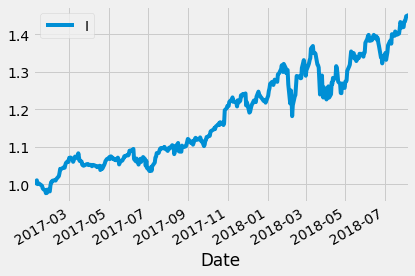

TotaAnnReturn = 27.956112
CAGR = 25.160000
Sharpe Ratio = 1.620000
Standard Deviation = 0.009551


In [57]:
testing = stock_etf_optimized_parameters_test_set()

Same parameters on whole dataset for trading program which selects only the top ETF for investment.

In [225]:
#Example1
# download dataframe
#data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
# download Panel
#data2 = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
#example2
#start = datetime.datetime(2017, 1, 1)
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)
#data.to_csv("C:\\Users\\Rosario\\Documents\\NeuralNetworksMachineLearning\\LSTMReturnPrediction\\data\\YahooSPY.csv")

#start_date=datetime.datetime(2003, 1, 1)
start_date_training=datetime.datetime(2010, 1, 5)
#end_date= datetime.datetime.now()
#end_date_training=datetime.datetime(2016, 12, 30)

#start_date_test=datetime.datetime(2017, 1, 3)
#end_date= datetime.datetime.now()
end_date_test=datetime.datetime(2018, 8, 6)


stock_list = ['XLU','XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']
#stock_list = ["SPY", "BND", "TLT"]
#stock_list = ["SPY", "TLT"]
#stock_list = ["SPY", "TLT", "SHY"]


stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."


#Below is for AP training data download    
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_test)
     df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
    

main_df.to_csv(stock_str+"AP_whole.csv")


#Below is for normal prices training data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"whole.csv")

In [58]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.whole.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_whole.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [59]:
print(dfP.shape)
print(dfAP.shape)

(2163, 19)
(2163, 19)


In [60]:
dfP = dfP.drop(dfP.index[0])
dfAP = dfAP.drop(dfAP.index[0])

In [61]:
#Reading in the predictions from the RF model

dfRF_total = pd.read_csv('svm-regression-ETF-whole-dataset.csv')

print (dfRF_total.shape)

(2162, 20)


In [62]:
dfRF_total.set_index('Date', inplace=True)

In [63]:
dfRF_total = dfRF_total[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [64]:
dfRF_total.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,0.038361,0.036945,0.034875,-0.274641,-0.058782,0.033313,0.002780,0.060684,0.03002,0.039330,0.064135,-0.171833,0.014235,0.064372,0.079452,0.039079,NaN,0.040358,0.002243
2018-08-02,0.040269,0.038206,0.034875,-0.262398,-0.061613,0.037326,0.002062,0.060684,0.03002,0.039337,0.064135,-0.172582,0.014162,0.064371,0.081329,0.039079,NaN,0.040360,0.002243
2018-08-03,0.039962,0.038708,0.034875,-0.260756,-0.061189,0.031541,0.001854,0.060684,0.03002,0.039336,0.064135,-0.179287,0.014062,0.064370,0.079532,0.039080,NaN,0.040352,0.002243
2018-08-06,0.038711,0.037895,0.034875,-0.260992,-0.061129,0.033935,-0.002006,0.060684,0.03002,0.039339,0.064135,-0.182566,0.014222,0.064371,0.081658,0.039080,NaN,0.040359,0.002243
2018-08-07,0.039210,0.037631,0.034875,-0.264846,-0.060786,0.031750,0.001103,0.060684,0.03002,0.039334,0.064135,-0.187613,0.014360,0.064371,0.079942,0.039079,NaN,0.040351,0.002243


In [65]:
def stock_etf_optimized_parameters_full_dataset_top_ETF_only():    
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 15 #20 Default
    Bperiods = 20 #66 Default
    Speriods = 5
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_total.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_total.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE SVM SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penializd
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return ()

Number of times "XLU" is selected 246.000000 
Number of times "XLV" is selected 104.000000 
Number of times "DIA" is selected 31.000000 
Number of times "GDX" is selected 66.000000 
Number of times "XLE" is selected 62.000000 
Number of times "XLY" is selected 155.000000 
Number of times "VNQ" is selected 104.000000 
Number of times "XLK" is selected 123.000000 
Number of times "XLF" is selected 28.000000 
Number of times "XLP" is selected 123.000000 
Number of times "IHI" is selected 257.000000 
Number of times "XRT" is selected 127.000000 
Number of times "RXI" is selected 111.000000 
Number of times "IYW" is selected 230.000000 
Number of times "VIS" is selected 134.000000 
Number of times "KBE" is selected 67.000000 
Number of times "SIL" is selected 39.000000 
Number of times "FXU" is selected 89.000000 
Number of times "SHY" is selected 66.000000 


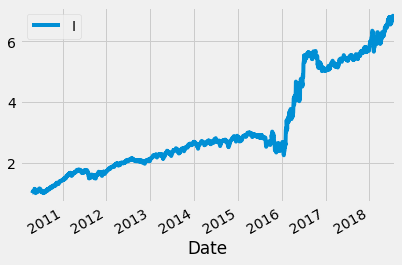

TotaAnnReturn = 67.201799
CAGR = 23.970000
Sharpe Ratio = 1.150000
Standard Deviation = 0.014039


In [66]:
testing_4 = stock_etf_optimized_parameters_full_dataset_top_ETF_only()